In [1]:
#packages
#basics
import os
import numpy as np
import pandas as pd

#images
import cv2

#modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#get the data
train = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/test.csv')

In [3]:
#Modify the Id such that each Id is the full image path. In the form
def train_id_to_path(x):
    return '/kaggle/input/petfinder-pawpularity-score/train/' + x + ".jpg"
def test_id_to_path(x):
    return '/kaggle/input/petfinder-pawpularity-score/test/' + x + ".jpg"

#Read in the data and drop unnecessary columns
#train = pd.read_csv('train.csv')
train = train.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

#test = pd.read_csv('test.csv')
test = test.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

#Add the .jpg extensions to the image file name ids
train["img_path"] = train["Id"].apply(train_id_to_path)
test["img_path"] = test["Id"].apply(test_id_to_path)

In [4]:
#Set the size image you want to use
image_height = 128
image_width = 128

#define a function that accepts an image url and outputs an eager tensor
def path_to_eagertensor(image_path):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.resize_with_pad(image, image_height, image_width) #optional with padding to retain original dimensions
    image = tf.image.resize(image, (image_height, image_width))
    return image

In [5]:
#get all the images in the training folder and put their tensors in a list
X = []
for img in train['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X.append(new_img_tensor)
    
print(type(X),len(X))
X = np.array(X)
print(type(X),X.shape)

<class 'list'> 9912
<class 'numpy.ndarray'> (9912, 128, 128, 3)


In [6]:
#get all the images in the test folder and put their tensors in a list
X_submission = []
for img in test['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X_submission.append(new_img_tensor)
    
print(type(X_submission),len(X_submission))
X_submission = np.array(X_submission)
print(type(X_submission),X_submission.shape)

<class 'list'> 8
<class 'numpy.ndarray'> (8, 128, 128, 3)


In [7]:
#grab the target variable. In our case, Pawpularity
y = train['Pawpularity']
print(type(y))

<class 'pandas.core.series.Series'>


In [8]:
#generate train - test splits  90% train - 10% test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

In [9]:
#Show the shape of each of the new arrays
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8920, 128, 128, 3) (992, 128, 128, 3) (8920,) (992,)


In [10]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1,activation='linear'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1,activation='linear'))

In [11]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [12]:
#compile the model
# import torch
model.compile(
    loss = 'mse',#torch.nn.SmoothL1Loss(),#torch.nn.BCEWithLogitsLoss, 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [13]:
data_augmentation =  ImageDataGenerator(
    rotation_range = 15, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    brightness_range=(0.1, 0.9),
    shear_range = 0.1,
    zoom_range = 0.15,
    horizontal_flip = True, 
    fill_mode = "nearest")
# ImageDataGenerator(shear_range=0.2,
#                             zoom_range=0.2,
#                             horizontal_flip=True)


In [14]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    data_augmentation.flow(x_train,y_train,batch_size=128),
    validation_data = (x_test,y_test),
    steps_per_epoch = len(x_train) // 128, 
    callbacks=[es_callback],
    epochs = 100
)

Epoch 1/100
69/69 [==============================] - 49s 559ms/step - loss: 1863.9241 - rmse: 43.1732 - val_loss: 1873.5574 - val_rmse: 43.2846
Epoch 2/100
69/69 [==============================] - 39s 563ms/step - loss: 1857.0607 - rmse: 43.0936 - val_loss: 1866.6938 - val_rmse: 43.2052
Epoch 3/100
69/69 [==============================] - 39s 563ms/step - loss: 1852.9064 - rmse: 43.0454 - val_loss: 1858.0990 - val_rmse: 43.1057
Epoch 4/100
69/69 [==============================] - 39s 567ms/step - loss: 1839.8611 - rmse: 42.8936 - val_loss: 1847.7725 - val_rmse: 42.9857
Epoch 5/100
69/69 [==============================] - 39s 560ms/step - loss: 1825.9691 - rmse: 42.7314 - val_loss: 1835.6521 - val_rmse: 42.8445
Epoch 6/100
69/69 [==============================] - 39s 560ms/step - loss: 1815.2614 - rmse: 42.6059 - val_loss: 1821.8083 - val_rmse: 42.6826
Epoch 7/100
69/69 [==============================] - 39s 565ms/step - loss: 1797.4969 - rmse: 42.3969 - val_loss: 1806.2751 - val_rmse: 

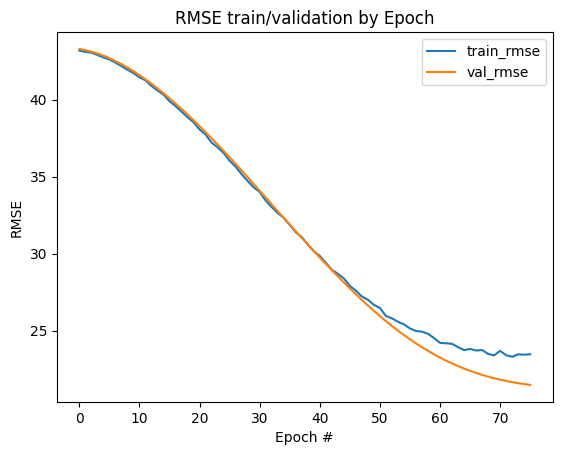

In [15]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse") #or mse
plt.plot(history.history["val_rmse"], label="val_rmse")
#plt.xticks(range(0,60))
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right")

In [16]:
y_pred = model.predict(x_test)
import math
import sklearn.metrics
mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print('RMSE of validation data: '+str(rmse)) #0.1 for both layers dropout & BS 128 - 21.19945112342183

31/31 [==============================] - 0s 3ms/step
RMSE of validation data: 21.488274607796615


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [17]:
#predict on the submission data
cnn_pred = model.predict(X_submission)
print(X_submission.shape, type(X_submission))
print(cnn_pred.shape, type(cnn_pred))

1/1 [==============================] - 0s 150ms/step
(8, 128, 128, 3) <class 'numpy.ndarray'>
(8, 1) <class 'numpy.ndarray'>


In [18]:
#put the submission predictions alongside their associated Ids
cnn = pd.DataFrame()
cnn['Id'] = test['Id']
cnn['Pawpularity'] = cnn_pred
cnn.to_csv('/kaggle/working/submission.csv',index=False)